# Character Level Language Model - Dinosaurus Island
- Our job is to give names to these dinosaur.
- To create new dinosaur names, we will build a character-level language model to generate new names. Our algorithm will learn the different name patterns, and randomly generate new names. 
- We'll be able to : 
    - store text data for processing using an RNN
    - Build a character-level text generation model using an RNN
    - Sample novel sequences in an RNN
    - Explain the vanishing/exploding gradient problem in RNNs
    - Apply gradient clipping as a solution for exploding gradients.

In [1]:
import numpy as np
import random
import pprint
import copy

# 1. Problem Statement
## 1.1 Dataset and Preprocessing
- To read the dataset of dinosaur names, create a list of unqiue characters (such as a-z), and compute the dataset and vocabulary size.

In [3]:
data = open('dinos.txt', 'r').read()
data = data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 19909 total characters and 27 unique characters in your data.


- The characters are a-z (26 characters) + '\n'
- The newline character '\n' plays a role similar to the <EOS> token.
    - '\n' indicates the end of the dinosaur name rather than the end of a sentence.
- char_to_ix : we'lll create a python dictionaryt (i.e a hash table) to map each character to an index from 0-26
- ix_to_char : Then we'll create a 2nd python dictionary that maps each index back to the corresponding character.
    - This will help us figure out which index corresponds to which character in the probability distribution output of the softmax layer.

In [5]:
chars = sorted(chars)
print(chars)

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
char_to_ix = {ch : i for i, ch in enumerate(chars)}
ix_to_char = {i : ch for i,ch in enumerate(chars)}
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(ix_to_char)

{   0: '\n',
    1: 'a',
    2: 'b',
    3: 'c',
    4: 'd',
    5: 'e',
    6: 'f',
    7: 'g',
    8: 'h',
    9: 'i',
    10: 'j',
    11: 'k',
    12: 'l',
    13: 'm',
    14: 'n',
    15: 'o',
    16: 'p',
    17: 'q',
    18: 'r',
    19: 's',
    20: 't',
    21: 'u',
    22: 'v',
    23: 'w',
    24: 'x',
    25: 'y',
    26: 'z'}


## 1.2 Overview of the Model
- Our model will have the following structure
    - Initialize parameters
    - Run the optimization loop
        - Forward propagation to compute the loss function.
        - Backward propapagation to compute the gradients with respect to the loss function
        - Clip the gradients to avoid exploding gradients
        - Using the gradients, update our parameters with the gradient descent update rule.
     - Return the learned parameters
     - 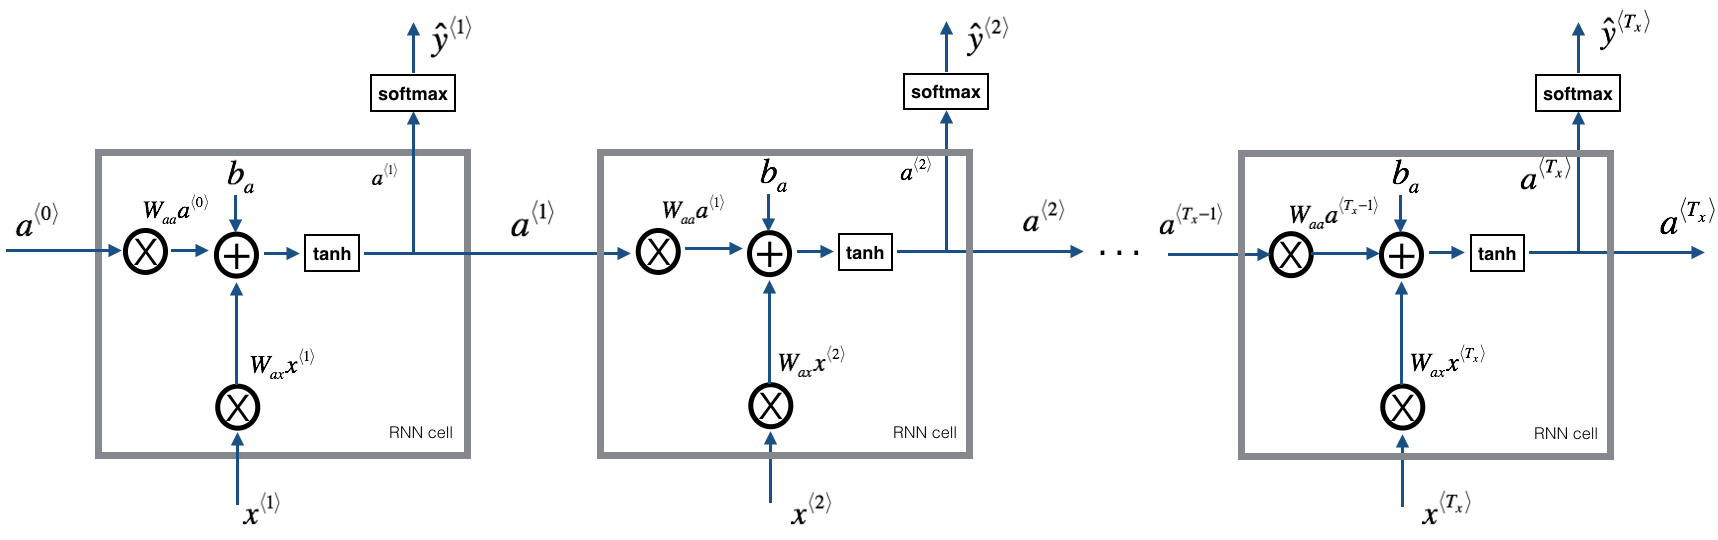
- At each time-step, the RNN tries to predict what the next character is, given the previous characters
- $\mathbf{X} = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a list of characters from the training set.
- $\mathbf{Y} = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$ is the same list of characters but shifted one character forward.
- At every time-step $t$, $y^{\langle t \rangle} = x^{\langle t+1 \rangle}$. The prediction at time t is the same as the input at time t+1

# 2. Building Blocks of the Model
- We will build 2 important blocks of the overall model : 
    1. Gradient clipping : To avoid exploding gradients
    2. Sampling : A technique used to generate characters
- We will then apply these 2 functions to build the model.

## 2.1 Clipping the Gradient in the Optimization Loop
- We will implement the clip function that we will call inside of our optimization loop
### Exploding Gradients
- When gradients are very large, they're called exploding gradients.
- Exploding gradients make the training process more difficult, because the updates may be so large that they 'overshoot' the optimal values during back propagation.
- The overall loop structure usually consists of : 
    - Forward pass
    - Cost computation
    - backward pass
    - parameter update
- Before updaing the parameters, we will perform gradient clipping to make sure that our gradients are not 'exploding'

### Gradient Clipping
- We will implement a function clip that takes in a dictionary of gradients and returns a clipped version of gradients, if needed.
    - There are different ways to clip gradients.
    - We will use a simple element-wise clipping procedure, in which every element of the gradient vector is clipped to fall b/w some range [-N, N].
    - For example, if the N = 10
        - The range is [-10, 10]
        - If any component of the gradient vector is greater than 10, it is set to 10.
        - If any components of the gradient vector is less than -10, it is set to -10.
        - If any components are b/w -10 and 10, they keep their original values.
        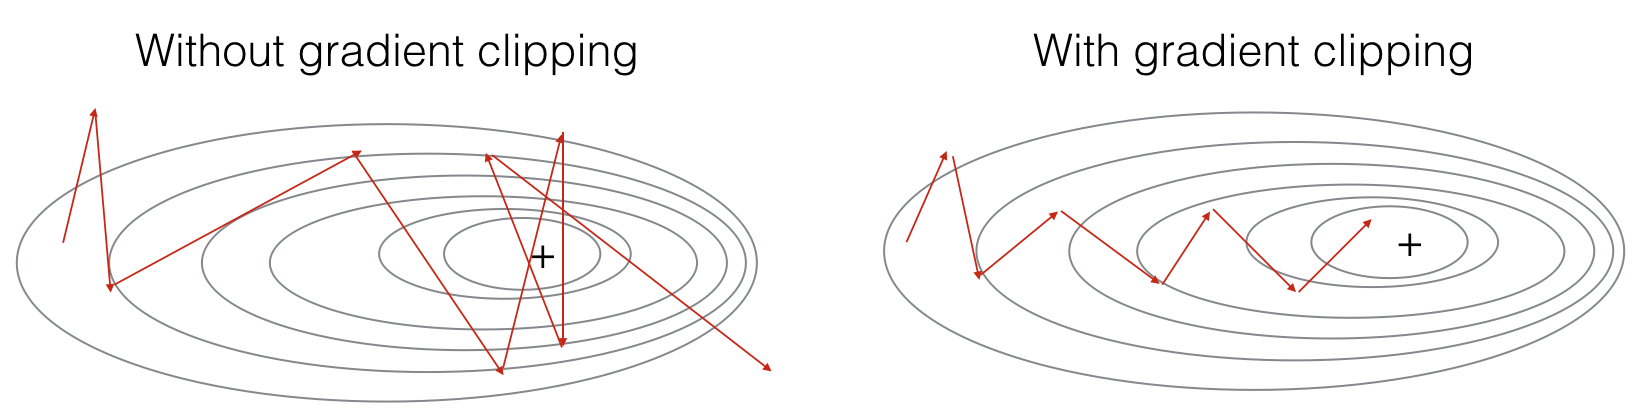
        

In [8]:
def clip(gradients, maxValue):
    '''
    Clips the gradients' values between minimum and maximum.
    
    Arguments:
    gradients -- a dictionary containing the gradients "dWaa", "dWax", "dWya", "db", "dby"
    maxValue -- everything above this number is set to this number, and everything less than -maxValue is set to -maxValue
    
    Returns: 
    gradients -- a dictionary with the clipped gradients.
    '''
    gradients = copy.deepcopy(gradients)
    
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']

    # Clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby]. (≈2 lines)
    for gradient in gradients:
        np.clip(gradients[gradient], -1*maxValue, maxValue, out = gradients[gradient] )

    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

In [9]:
def clip_test(target, mValue):
    print(f"\nGradients for mValue={mValue}")
    np.random.seed(3)
    dWax = np.random.randn(5, 3) * 10
    dWaa = np.random.randn(5, 5) * 10
    dWya = np.random.randn(2, 5) * 10
    db = np.random.randn(5, 1) * 10
    dby = np.random.randn(2, 1) * 10
    gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "db": db, "dby": dby}

    gradients2 = target(gradients, mValue)
    print("gradients[\"dWaa\"][1][2] =", gradients2["dWaa"][1][2])
    print("gradients[\"dWax\"][3][1] =", gradients2["dWax"][3][1])
    print("gradients[\"dWya\"][1][2] =", gradients2["dWya"][1][2])
    print("gradients[\"db\"][4] =", gradients2["db"][4])
    print("gradients[\"dby\"][1] =", gradients2["dby"][1])
    
clip_test(clip, 10)
clip_test(clip, 5)


Gradients for mValue=10
gradients["dWaa"][1][2] = 10.0
gradients["dWax"][3][1] = -10.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [10.]
gradients["dby"][1] = [8.45833407]

Gradients for mValue=5
gradients["dWaa"][1][2] = 5.0
gradients["dWax"][3][1] = -5.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [5.]
gradients["dby"][1] = [5.]


## 2.2 Sampling
- Now, assuming that our model is trained, and we would like to generate new text(characters). The process of generation is as follows :
    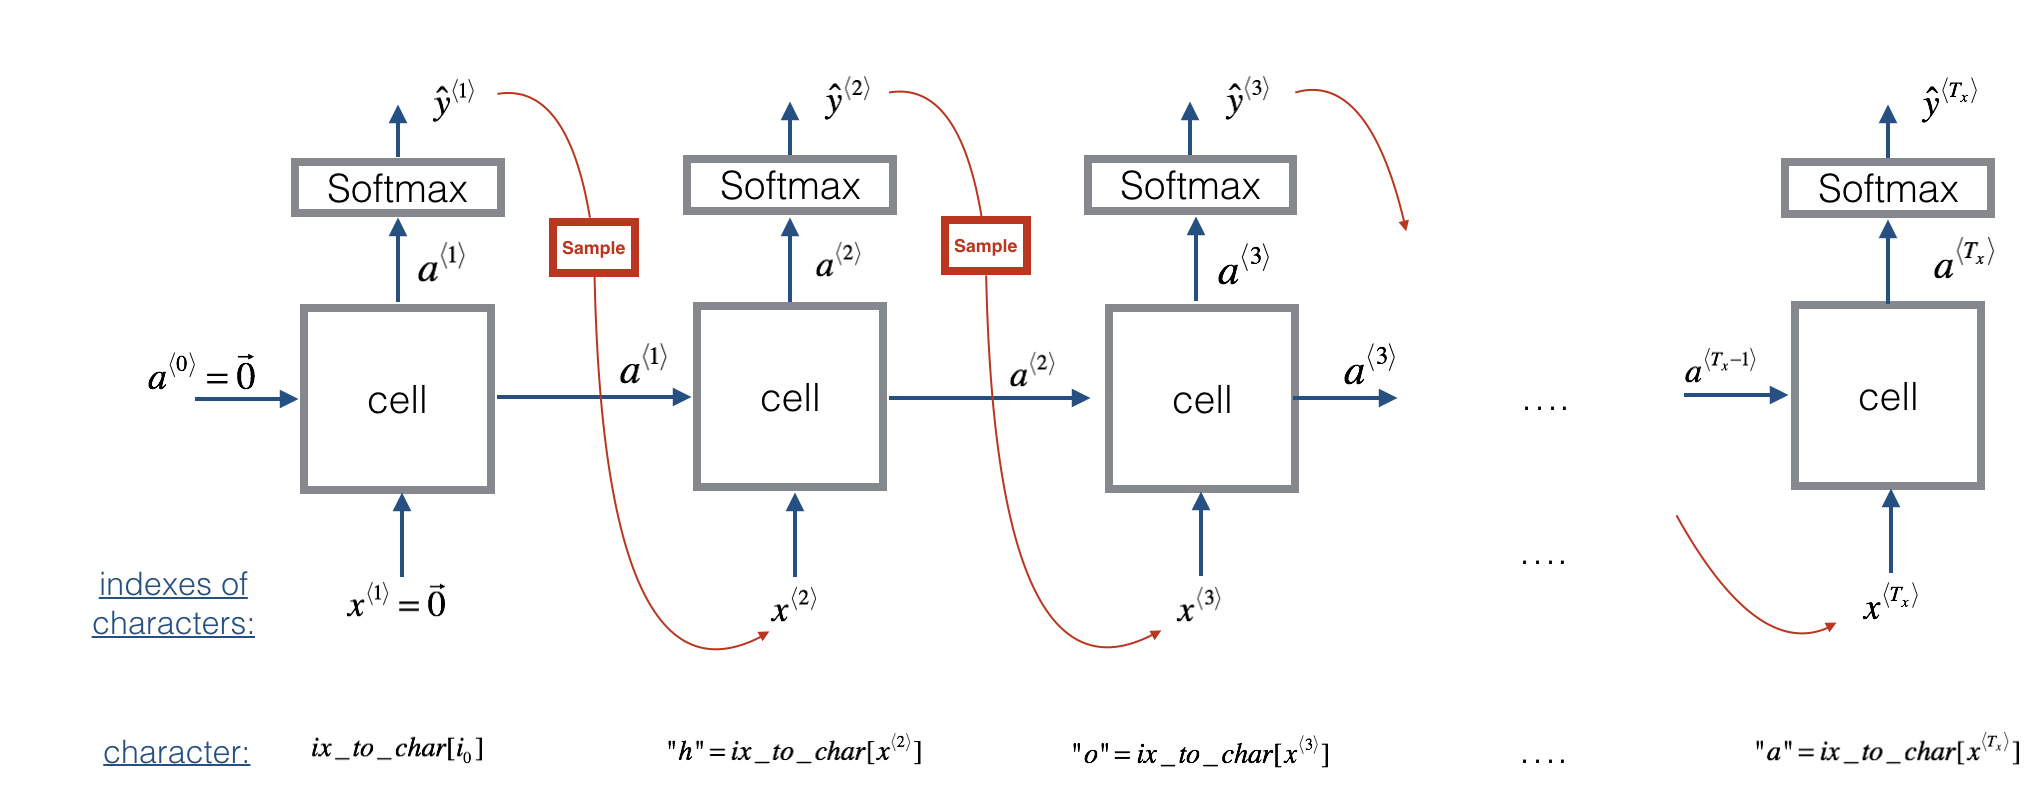

### sample
- Implemenet the sample function to sample characters
- We need to carry out 4 steps
    - Step1 : Input the 'dummy' vector of zeros $x^{\langle 1 \rangle} = \vec{0}$.
        - This is the default input before we've generated any characters. We also set $a^{\langle 0 \rangle} = \vec{0}$
   - Step2 : Run one step of forward propagation to get $a^{\langle 1 \rangle}$ and $\hat{y}^{\langle 1 \rangle}$ .Here are the equations : 
       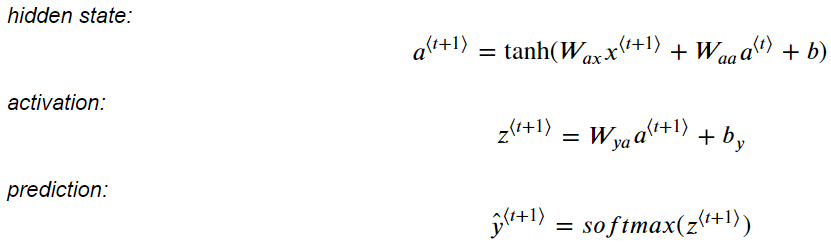
    - Step 3 : Sampling
        - now that we have $y^{\langle t+1 \rangle}$, we want to select the next letter in the dinosaur name. If we select the most probable, the model will always generate the same result given a starting letter. To make the results more intresting, use np.random.choice to select a next letter that is likely, but not always the same.
        - Pick the next character's index according to the probability distribution specified by $\hat{y}^{\langle 1 \rangle}$
        - this means that if $\hat{y}^{\langle t+1 \rangle }_i = 0.16$, we will pick the index 'i' with 16% probability.
    - Step 4 : Update to $x^{\langle t \rangle }$ 
        - The last step to implement in sample() is to upload the variable x, which currently stores $x^{\langle t \rangle }$, with the value of $x^{\langle t + 1 \rangle }$. 
        - We will represent $x^{\langle t + 1 \rangle }$ by creating a one-hot vector corresponding to the character that we have chosen as our prediction.
        - We will then forward propagate $x^{\langle t + 1 \rangle }$ in step1 and keep repeating the process until we get a '\n' character, indicating that we have reached the end of the dinosaur name.

In [13]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [14]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: sample

def sample(parameters, char_to_ix, seed):
    """
    Sample a sequence of characters according to a sequence of probability distributions output of the RNN

    Arguments:
    parameters -- Python dictionary containing the parameters Waa, Wax, Wya, by, and b. 
    char_to_ix -- Python dictionary mapping each character to an index.
    seed -- Used for grading purposes. Do not worry about it.

    Returns:
    indices -- A list of length n containing the indices of the sampled characters.
    """
    
    # Retrieve parameters and relevant shapes from "parameters" dictionary
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    
    ### START CODE HERE ###
    # Step 1: Create the a zero vector x that can be used as the one-hot vector 
    # Representing the first character (initializing the sequence generation). (≈1 line)
    x = np.zeros((vocab_size, 1))
    # Step 1': Initialize a_prev as zeros (≈1 line)
    a_prev = np.zeros((n_a, 1))
    
    # Create an empty list of indices. This is the list which will contain the list of indices of the characters to generate (≈1 line)
    indices = []
    
    # idx is the index of the one-hot vector x that is set to 1
    # All other positions in x are zero.
    # Initialize idx to -1
    idx = -1 
    
    # Loop over time-steps t. At each time-step:
    # Sample a character from a probability distribution 
    # And append its index (`idx`) to the list "indices". 
    # You'll stop if you reach 50 characters 
    # (which should be very unlikely with a well-trained model).
    # Setting the maximum number of characters helps with debugging and prevents infinite loops. 
    counter = 0
    newline_character = char_to_ix['\n']
    
    while (idx != newline_character and counter != 50):
        
        # Step 2: Forward propagate x using the equations (1), (2) and (3)
        a = np.tanh( np.dot(Wax, x) + np.dot(Waa, a_prev) + b)
        z = np.dot(Wya, a) + by
        y = softmax(z)
        
        # For grading purposes
        np.random.seed(counter + seed) 
        
        # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
        # (see additional hints above)
        idx = np.random.choice(list(range(vocab_size)), p = y.ravel())

        # Append the index to "indices"
        indices.append(idx)
        
        # Step 4: Overwrite the input x with one that corresponds to the sampled index `idx`.
        # (see additional hints above)
        x = np.zeros((vocab_size, 1))
        x[idx] = 1
        
        # Update "a_prev" to be "a"
        a_prev = a
        
        # for grading purposes
        seed += 1
        counter +=1

    if (counter == 50):
        indices.append(char_to_ix['\n'])
    
    return indices

In [15]:
def sample_test(target):
    np.random.seed(24)
    _, n_a = 20, 100
    Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
    b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}


    indices = target(parameters, char_to_ix, 0)
    print("Sampling:")
    print("list of sampled indices:\n", indices)
    print("list of sampled characters:\n", [ix_to_char[i] for i in indices])
    
sample_test(sample)

Sampling:
list of sampled indices:
 [23, 16, 26, 26, 24, 3, 21, 1, 7, 24, 15, 3, 25, 20, 6, 13, 10, 8, 20, 12, 2, 0]
list of sampled characters:
 ['w', 'p', 'z', 'z', 'x', 'c', 'u', 'a', 'g', 'x', 'o', 'c', 'y', 't', 'f', 'm', 'j', 'h', 't', 'l', 'b', '\n']


- Very large or 'exploding' gradients updates can be so large that they overshoot the optimal values during back propagation making training difficult.
    - Clip gradients before updating the paramaters to avoid exploding gradients.
- Sampling is a technique we can use to pick the index of the next character according to a probability distribution.
    - To begin character-level sampling :
        - Input a 'dummy' vector of zeros as a default input
        - Run one step of forward propagation to get a<1> (our 1st character) and y_hat<1> (propabability distribution for the following character)
        - When sampling avoid generating the same result each time given the starting letter (and make our names more intresting).

# 3. Building the Language Model
- To build the charater-level language model for text generation
## 3.1 Gradient Descent
- We will implement a function performing one step of stochastic gradient descent with clipped gradients. We'll go through the training examples one at a time, so the optimization algorithm will be stochastic gradient descent.
- Here are the steps of common optimization loop for an RNN.
    1. Forward propagate through the RNN to compute the loss.
    2. Backward propagate through time to compute the gradients of the loss with respect to the parameters.
    3. Clip the gradients
    4. Update the parameters using gradient descent

In [17]:
def initialize_parameters(n_a, n_x, n_y):
    """
    Initialize parameters with small random values
    
    Returns:
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    """
    np.random.seed(1)
    Wax = np.random.randn(n_a, n_x)*0.01 # input to hidden
    Waa = np.random.randn(n_a, n_a)*0.01 # hidden to hidden
    Wya = np.random.randn(n_y, n_a)*0.01 # hidden to output
    b = np.zeros((n_a, 1)) # hidden bias
    by = np.zeros((n_y, 1)) # output bias
    
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b,"by": by}
    
    return parameters

def rnn_step_forward(parameters, a_prev, x):
    
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    a_next = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b) # hidden state
    p_t = softmax(np.dot(Wya, a_next) + by) # unnormalized log probabilities for next chars # probabilities for next chars 
    
    return a_next, p_t

def rnn_step_backward(dy, gradients, parameters, x, a, a_prev):
    
    gradients['dWya'] += np.dot(dy, a.T)
    gradients['dby'] += dy
    da = np.dot(parameters['Wya'].T, dy) + gradients['da_next'] # backprop into h
    daraw = (1 - a * a) * da # backprop through tanh nonlinearity
    gradients['db'] += daraw
    gradients['dWax'] += np.dot(daraw, x.T)
    gradients['dWaa'] += np.dot(daraw, a_prev.T)
    gradients['da_next'] = np.dot(parameters['Waa'].T, daraw)
    return gradients

def update_parameters(parameters, gradients, lr):

    parameters['Wax'] += -lr * gradients['dWax']
    parameters['Waa'] += -lr * gradients['dWaa']
    parameters['Wya'] += -lr * gradients['dWya']
    parameters['b']  += -lr * gradients['db']
    parameters['by']  += -lr * gradients['dby']
    return parameters

def rnn_forward(X, Y, a0, parameters, vocab_size = 27):
    
    # Initialize x, a and y_hat as empty dictionaries
    x, a, y_hat = {}, {}, {}
    
    a[-1] = np.copy(a0)
    
    # initialize your loss to 0
    loss = 0
    
    for t in range(len(X)):
        
        # Set x[t] to be the one-hot vector representation of the t'th character in X.
        # if X[t] == None, we just have x[t]=0. This is used to set the input for the first timestep to the zero vector. 
        x[t] = np.zeros((vocab_size,1)) 
        if (X[t] != None):
            x[t][X[t]] = 1
        
        # Run one step forward of the RNN
        a[t], y_hat[t] = rnn_step_forward(parameters, a[t-1], x[t])
        
        # Update the loss by substracting the cross-entropy term of this time-step from it.
        loss -= np.log(y_hat[t][Y[t],0])
        
    cache = (y_hat, a, x)
        
    return loss, cache

def rnn_backward(X, Y, parameters, cache):
    # Initialize gradients as an empty dictionary
    gradients = {}
    
    # Retrieve from cache and parameters
    (y_hat, a, x) = cache
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    
    # each one should be initialized to zeros of the same dimension as its corresponding parameter
    gradients['dWax'], gradients['dWaa'], gradients['dWya'] = np.zeros_like(Wax), np.zeros_like(Waa), np.zeros_like(Wya)
    gradients['db'], gradients['dby'] = np.zeros_like(b), np.zeros_like(by)
    gradients['da_next'] = np.zeros_like(a[0])
    
    ### START CODE HERE ###
    # Backpropagate through time
    for t in reversed(range(len(X))):
        dy = np.copy(y_hat[t])
        dy[Y[t]] -= 1
        gradients = rnn_step_backward(dy, gradients, parameters, x[t], a[t], a[t-1])
    ### END CODE HERE ###
    
    return gradients, a



In [18]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: optimize

def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """
    Execute one step of the optimization to train the model.
    
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """

    # Forward propagate through time (≈1 line)
    loss, cache = rnn_forward(X, Y, a_prev, parameters)
    
    # Backpropagate through time (≈1 line)
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # Clip your gradients between -5 (min) and 5 (max) (≈1 line)
    gradients = clip(gradients, 5)
    
    # Update parameters (≈1 line)
    parameters = update_parameters(parameters, gradients, learning_rate)

    
    return loss, gradients, a[len(X)-1]

In [19]:
def optimize_test(target):
    np.random.seed(1)
    vocab_size, n_a = 27, 100
    a_prev = np.random.randn(n_a, 1)
    Wax, Waa, Wya = np.random.randn(n_a, vocab_size), np.random.randn(n_a, n_a), np.random.randn(vocab_size, n_a)
    b, by = np.random.randn(n_a, 1), np.random.randn(vocab_size, 1)
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}
    X = [12, 3, 5, 11, 22, 3]
    Y = [4, 14, 11, 22, 25, 26]
    old_parameters = copy.deepcopy(parameters)
    loss, gradients, a_last = target(X, Y, a_prev, parameters, learning_rate = 0.01)
    print("Loss =", loss)
    print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
    print("np.argmax(gradients[\"dWax\"]) =", np.argmax(gradients["dWax"]))
    print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
    print("gradients[\"db\"][4] =", gradients["db"][4])
    print("gradients[\"dby\"][1] =", gradients["dby"][1])
    print("a_last[4] =", a_last[4])


optimize_test(optimize)

Loss = 126.5039757216536
gradients["dWaa"][1][2] = 0.1947093153472186
np.argmax(gradients["dWax"]) = 93
gradients["dWya"][1][2] = -0.007773876032003953
gradients["db"][4] = [-0.06809825]
gradients["dby"][1] = [0.01538192]
a_last[4] = [-1.]


## 3.2 Training the Model
- Given the dataset of dinosaur names, we'll use each lime of the dataset (one name) as one training example. 
- Even 2000 steps of stochastic gradient descent, we will sample several randomly chosen names to see how the algorithm is goind

In [28]:
def get_initial_loss(vocab_size, seq_length):
    return -np.log(1.0/vocab_size)*seq_length

def smooth(loss, cur_loss):
    return loss * 0.999 + cur_loss * 0.001

def print_sample(sample_ix, ix_to_char):
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    txt = txt[0].upper() + txt[1:]  # capitalize first character 
    print ('%s' % (txt, ), end='')
    

def get_sample(sample_ix, ix_to_char):
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    txt = txt[0].upper() + txt[1:]  # capitalize first character 
    return txt

In [29]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: model

def model(data_x, ix_to_char, char_to_ix, num_iterations = 35000, n_a = 50, dino_names = 7, vocab_size = 27, verbose = False):
    """
    Trains the model and generates dinosaur names. 
    
    Arguments:
    data_x -- text corpus, divided in words
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    dino_names -- number of dinosaur names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text (size of the vocabulary)
    
    Returns:
    parameters -- learned parameters
    """
    
    # Retrieve n_x and n_y from vocab_size
    n_x, n_y = vocab_size, vocab_size
    
    # Initialize parameters
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # Initialize loss (this is required because we want to smooth our loss)
    loss = get_initial_loss(vocab_size, dino_names)
    
    # Build list of all dinosaur names (training examples).
    examples = [x.strip() for x in data_x]
    
    # Shuffle list of all dinosaur names
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # Initialize the hidden state of your LSTM
    a_prev = np.zeros((n_a, 1))
    
    # for grading purposes
    last_dino_name = "abc"
    
    # Optimization loop
    for j in range(num_iterations):
        
        ### START CODE HERE ###
        
        # Set the index `idx` (see instructions above)
        idx = j % len(examples)
        
        # Set the input X (see instructions above)
        single_example = examples[idx]
        single_example_chars = [c for c in single_example]
        single_example_ix = [char_to_ix[c] for c in single_example_chars]
        X = [None] + single_example_ix
        
        # Set the labels Y (see instructions above)
        ix_newline = char_to_ix['\n']
        Y = X[1:] + [ix_newline]

        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters)
        
        ### END CODE HERE ###
        
        # debug statements to aid in correctly forming X, Y
        if verbose and j in [0, len(examples) -1, len(examples)]:
            print("j = " , j, "idx = ", idx,) 
        if verbose and j in [0]:
            print("single_example =", single_example)
            print("single_example_chars", single_example_chars)
            print("single_example_ix", single_example_ix)
            print(" X = ", X, "\n", "Y =       ", Y, "\n")
        
        # to keep the loss smooth.
        loss = smooth(loss, curr_loss)

        # Every 2000 Iteration, generate "n" characters thanks to sample() to check if the model is learning properly
        if j % 2000 == 0:
            
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')
            
            # The number of dinosaur names to print
            seed = 0
            for name in range(dino_names):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_ix, seed)
                last_dino_name = get_sample(sampled_indices, ix_to_char)
                print(last_dino_name.replace('\n', ''))
                
                seed += 1  # To get the same result (for grading purposes), increment the seed by one. 
      
            print('\n')
        
    return parameters, last_dino_name

In [30]:
parameters, last_name = model(data.split("\n"), ix_to_char, char_to_ix, 22001, verbose = True)

j =  0 idx =  0
single_example = turiasaurus
single_example_chars ['t', 'u', 'r', 'i', 'a', 's', 'a', 'u', 'r', 'u', 's']
single_example_ix [20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19]
 X =  [None, 20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19] 
 Y =        [20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19, 0] 

Iteration: 0, Loss: 23.087336

Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu


j =  1535 idx =  1535
j =  1536 idx =  0
Iteration: 2000, Loss: 27.884160

Liusskeomnolxeros
Hmdaairus
Hytroligoraurus
Lecalosapaus
Xusicikoraurus
Abalpsamantisaurus
Tpraneronxeros


Iteration: 4000, Loss: 25.901815

Mivrosaurus
Inee
Ivtroplisaurus
Mbaaisaurus
Wusichisaurus
Cabaselachus
Toraperlethosdarenitochusthiamamumamaon


Iteration: 6000, Loss: 24.608779

Onwusceomosaurus
Lieeaerosaurus
Lxussaurus
Oma
Xusteonosaurus
Eeahosaurus
Toreonosaurus


Iteration: 8000, Loss: 24.070350

Onxusichepriuon
Kilabersaurus
Lutrodon
Omaaerosaurus
Xutrcheps
Edaksoje
Trodi

- LSTMs instead of the basic RNN to capture longer-range dependencies
- The model is a deeper, stacker LSTM model (2 layer)
- Using keras instead of Python to simplify the code.